In [1]:
import os

os.chdir(r"C:\Users\adema\VS Code\Projet radiothérapie\projet_S7_radio")

In [2]:
from ApplicationsUNet.loadData import ThoraxDataLoader
import SimpleITK 
import skimage.io as io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras import layers, Model

from matplotlib import cm
from matplotlib.colors import ListedColormap

In [3]:
loader = ThoraxDataLoader("./Data/Data_Medical/MCsimulations")
x_dataset = loader.load_all_samples("LS")
y_dataset = loader.load_all_samples("HS")

sample_0001 chargé avec succès.
sample_0002 chargé avec succès.
sample_0003 chargé avec succès.
sample_0004 chargé avec succès.
sample_0005 chargé avec succès.
sample_0006 chargé avec succès.
sample_0007 chargé avec succès.
sample_0008 chargé avec succès.
sample_0009 chargé avec succès.
sample_0010 chargé avec succès.
sample_0011 chargé avec succès.
sample_0012 chargé avec succès.
sample_0013 chargé avec succès.
sample_0014 chargé avec succès.
sample_0015 chargé avec succès.
sample_0016 chargé avec succès.
sample_0017 chargé avec succès.
sample_0018 chargé avec succès.
sample_0019 chargé avec succès.
sample_0020 chargé avec succès.
sample_0021 chargé avec succès.
sample_0022 chargé avec succès.
sample_0023 chargé avec succès.
sample_0024 chargé avec succès.
sample_0025 chargé avec succès.
sample_0026 chargé avec succès.
sample_0027 chargé avec succès.
sample_0028 chargé avec succès.
sample_0029 chargé avec succès.
sample_0030 chargé avec succès.
sample_0031 chargé avec succès.
sample_0

In [23]:
train_lenght = int(0.80*x_dataset.shape[0])

x_train = x_dataset[:90,:,:]
y_train = y_dataset[:90,:,:]

x_val = x_dataset[90:100,:,:]
y_val = y_dataset[90:100,:,:]

x_test = x_dataset[100:120,:,:]
y_test = y_dataset[100:120,:,:]

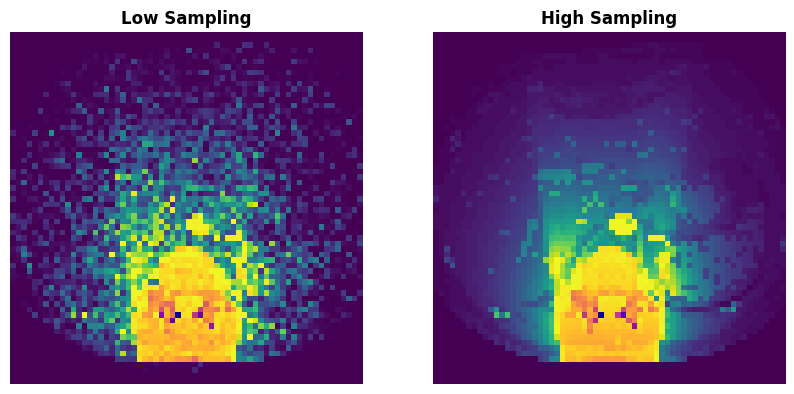

In [15]:
newcmp = loader.newcmp

LS = x_train[0,:,:]
HS = y_train[0,:,:]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(LS, interpolation=None, cmap=newcmp)
axes[0].set_title('Low Sampling',fontweight='bold')
axes[0].axis('off')

axes[1].imshow(HS, interpolation=None, cmap=newcmp)
axes[1].set_title('High Sampling',fontweight='bold')
axes[1].axis('off')

plt.show()

# UNet Model with PyTorch

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    
    def conv_block(self, in_channels, out_channels):
        """Bloc de convolution : Conv2D -> ReLU -> Conv2D -> ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        
        c2 = self.enc2(p1)
        p2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        
        c3 = self.enc3(p2)
        p3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        
        c4 = self.enc4(p3)
        p4 = F.max_pool2d(c4, kernel_size=2, stride=2)
        
        # Bottleneck
        bn = self.bottleneck(p4)
        
        # Decoder
        u4 = self.upconv4(bn)
        u4 = torch.cat((u4, c4), dim=1)  # Skip connection
        c5 = self.dec4(u4)
        
        u3 = self.upconv3(c5)
        u3 = torch.cat((u3, c3), dim=1)  # Skip connection
        c6 = self.dec3(u3)
        
        u2 = self.upconv2(c6)
        u2 = torch.cat((u2, c2), dim=1)  # Skip connection
        c7 = self.dec2(u2)
        
        u1 = self.upconv1(c7)
        u1 = torch.cat((u1, c1), dim=1)  # Skip connection
        c8 = self.dec1(u1)
        
        # Output
        outputs = torch.sigmoid(self.output_conv(c8))  # Sigmoid pour ramener entre [0, 1]
        return outputs

In [7]:
unettest = UNet()
batch_size = 5
summary(unettest, input_size=(1, 64, 64), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [5, 64, 64, 64]             640
              ReLU-2            [5, 64, 64, 64]               0
            Conv2d-3            [5, 64, 64, 64]          36,928
              ReLU-4            [5, 64, 64, 64]               0
            Conv2d-5           [5, 128, 32, 32]          73,856
              ReLU-6           [5, 128, 32, 32]               0
            Conv2d-7           [5, 128, 32, 32]         147,584
              ReLU-8           [5, 128, 32, 32]               0
            Conv2d-9           [5, 256, 16, 16]         295,168
             ReLU-10           [5, 256, 16, 16]               0
           Conv2d-11           [5, 256, 16, 16]         590,080
             ReLU-12           [5, 256, 16, 16]               0
           Conv2d-13             [5, 512, 8, 8]       1,180,160
             ReLU-14             [5, 51

In [24]:
x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

x_val = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

x_train.shape

torch.Size([90, 1, 64, 64])

In [28]:
batch_size = 10

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout, etc.)
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Passage dans le modèle
            outputs = model(inputs)
            
            # Calcul de la perte
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Collecter les prédictions et les vraies étiquettes
            preds = outputs.argmax(dim=1)  # Utilisez `argmax` si c'est une tâche de classification multi-classe
            all_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU et les collecter
            all_targets.extend(targets.cpu().numpy())  # Idem pour les cibles
            
    # Calcul de la perte moyenne de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.MSELoss()  # Loss pour le débruitage
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Déplacer vers GPU si disponible

        # Initialiser les gradients
        optimizer.zero_grad()

        # Passer les données dans le modèle
        outputs = model(inputs)

        # Calculer la perte
        loss = criterion(outputs, targets)

        # Rétropropagation
        loss.backward()

        # Mise à jour des poids
        optimizer.step()

        # Accumuler la perte
        running_loss += loss.item()

        # Afficher la perte
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss:.4f}")
    
    # Évaluation sur le jeu de validation
    evaluate_model(model, val_loader, criterion, device)

    # Vous pouvez ajouter des fonctions d'évaluation ici (sur un jeu de validation, par exemple)

torch.save(model.state_dict(), r"ApplicationsUNet\UNet LS-HS\models\UNet.pth")
print("Entraînement terminé")

Epoch [1/10], Batch [1/9], Loss: 0.2554
Epoch [1/10], Batch [2/9], Loss: 0.0061
Epoch [1/10], Batch [3/9], Loss: 0.0066
Epoch [1/10], Batch [4/9], Loss: 0.0060
Epoch [1/10], Batch [5/9], Loss: 0.0060
Epoch [1/10], Batch [6/9], Loss: 0.0064
Epoch [1/10], Batch [7/9], Loss: 0.0065
Epoch [1/10], Batch [8/9], Loss: 0.0061
Epoch [1/10], Batch [9/9], Loss: 0.0062
Validation Loss: 0.0087
Epoch [2/10], Batch [1/9], Loss: 0.0066
Epoch [2/10], Batch [2/9], Loss: 0.0058
Epoch [2/10], Batch [3/9], Loss: 0.0059
Epoch [2/10], Batch [4/9], Loss: 0.0070
Epoch [2/10], Batch [5/9], Loss: 0.0064
Epoch [2/10], Batch [6/9], Loss: 0.0057
Epoch [2/10], Batch [7/9], Loss: 0.0060
Epoch [2/10], Batch [8/9], Loss: 0.0063
Epoch [2/10], Batch [9/9], Loss: 0.0063
Validation Loss: 0.0087
Epoch [3/10], Batch [1/9], Loss: 0.0058
Epoch [3/10], Batch [2/9], Loss: 0.0066
Epoch [3/10], Batch [3/9], Loss: 0.0059
Epoch [3/10], Batch [4/9], Loss: 0.0063
Epoch [3/10], Batch [5/9], Loss: 0.0070
Epoch [3/10], Batch [6/9], Loss:

In [ ]:
model = UNet()
model.load_state_dict(torch.load(r"ApplicationsUNet\UNet LS-HS\models\UNet.pth"))

C:\Users\adema\AppData\Local\Temp\ipykernel_8380\1915182587.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"ApplicationsUNet\UNet LS-H

<All keys matched successfully>

torch.Size([20, 1, 64, 64]) torch.Size([20, 1, 64, 64])


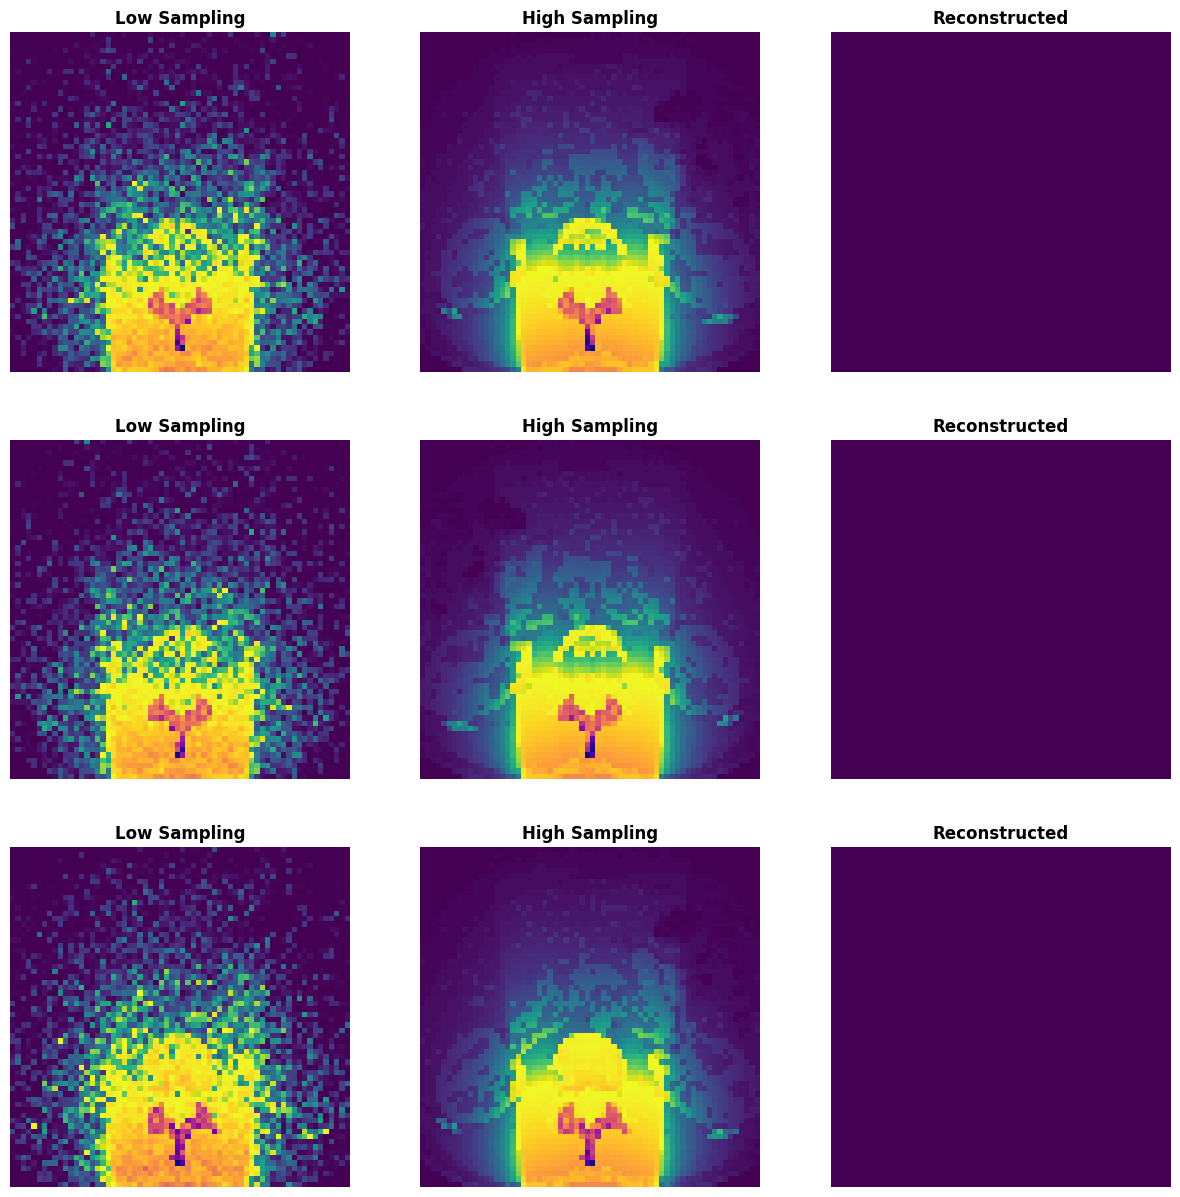

In [25]:
model.eval()

print(x_test.shape, y_test.shape)

with torch.no_grad():
    y_pred = model(x_test).cpu()

y_pred = y_pred.squeeze(1).numpy()
y_test = y_test.squeeze(1).numpy()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    axes[i, 0].imshow(x_test[i, 0], cmap=newcmp)
    axes[i, 0].set_title('Low Sampling', fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(y_test[i], cmap=newcmp)
    axes[i, 1].set_title('High Sampling', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_pred[i], cmap=newcmp)
    axes[i, 2].set_title('Reconstructed', fontweight='bold')
    axes[i, 2].axis('off')

# UNet Model with Tensorflow

In [ ]:
train_lenght = int(0.80*x_dataset.shape[0])

x_train = x_dataset[:train_lenght,:,:]
x_train = np.expand_dims(x_train, axis=-1)
y_train = y_dataset[:train_lenght,:,:]
y_train = np.expand_dims(y_train, axis=-1)

x_test = x_dataset[train_lenght:,:,:]
x_test = np.expand_dims(x_test, axis=-1)
y_test = y_dataset[train_lenght:,:,:]
y_test = np.expand_dims(y_test, axis=-1)

torch.Size([5248, 64, 64])

In [ ]:
def unet_denoiser(input_shape=(64, 64, 1)):
    """
    Crée un modèle U-Net pour le débruitage d'images en niveaux de gris.
    Args:
        input_shape (tuple): Dimensions de l'entrée (hauteur, largeur, canaux).
    Returns:
        model (tf.keras.Model): Modèle U-Net.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder (Contraction)
    c1 = conv_block(inputs, 64)   # [64, 64, 64]
    p1 = layers.MaxPooling2D((2, 2))(c1)  # [32, 32, 64]

    c2 = conv_block(p1, 128)  # [32, 32, 128]
    p2 = layers.MaxPooling2D((2, 2))(c2)  # [16, 16, 128]

    c3 = conv_block(p2, 256)  # [16, 16, 256]
    p3 = layers.MaxPooling2D((2, 2))(c3)  # [8, 8, 256]

    c4 = conv_block(p3, 512)  # [8, 8, 512]
    p4 = layers.MaxPooling2D((2, 2))(c4)  # [4, 4, 512]

    # Bottleneck
    bn = conv_block(p4, 1024)  # [4, 4, 1024]

    # Decoder (Expansion)
    u4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(bn)  # [8, 8, 512]
    u4 = layers.concatenate([u4, c4])  # Skip connection
    c5 = conv_block(u4, 512)  # [8, 8, 512]

    u3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c5)  # [16, 16, 256]
    u3 = layers.concatenate([u3, c3])  # Skip connection
    c6 = conv_block(u3, 256)  # [16, 16, 256]

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c6)  # [32, 32, 128]
    u2 = layers.concatenate([u2, c2])  # Skip connection
    c7 = conv_block(u2, 128)  # [32, 32, 128]

    u1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c7)  # [64, 64, 64]
    u1 = layers.concatenate([u1, c1])  # Skip connection
    c8 = conv_block(u1, 64)  # [64, 64, 64]

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c8)  # [64, 64, 1]

    # Model
    model = Model(inputs, outputs)
    return model


def conv_block(input_tensor, num_filters):
    """
    Bloc de convolution : Conv2D -> ReLU -> Conv2D -> ReLU.
    Args:
        input_tensor: Tenseur d'entrée.
        num_filters: Nombre de filtres pour les convolutions.
    Returns:
        Tenseur après les convolutions.
    """
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(input_tensor)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 256) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 4, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 4, 4,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 8, 8, 512) │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1024)             │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Création du modèle
input_shape = (64, 64, 1)  # Image en niveaux de gris (1 canal)
model = unet_denoiser(input_shape)
model.summary()
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.1,
    verbose=2
)